# Non Linear Manifold Identification

In [1]:
%matplotlib inline
import os 
#import ipyparams
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import sklearn
import sklearn.datasets as ds
from sklearn.metrics.pairwise import euclidean_distances
from sklearn.neighbors import NearestNeighbors
from sklearn import manifold
import scipy
from scipy.linalg import eigh
from tqdm import tqdm
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
matplotlib.rcParams.update({'font.size': 20})
seed = 1337 # Highly optimised seed for isomap computation speed.
np.random.seed(seed)
torch.manual_seed(seed)

## Dataset

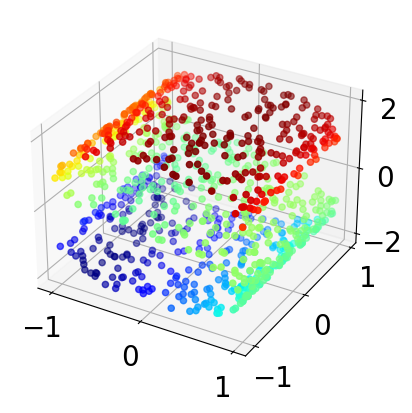

In [2]:
n_samples = 1000
X, _ = ds.make_s_curve(n_samples=n_samples, noise=0)
X = X-X.mean(0)
anchor = np.amin(X,0)
dx = X.shape[1]
coloring = ((X[:,0]-anchor[0])**2 + (X[:,2]-anchor[2])**2)**0.5
coloring = coloring-coloring.min()
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
ax.scatter(*X.T,c=coloring,cmap=plt.cm.jet)

## K means

/tmp/ipykernel_8901/1089707551.py:17: RuntimeWarning: Mean of empty slice.
  barycenters = X[indexes==i].mean(axis=0)
/home/tau/emenier/miniconda3/envs/LED/lib/python3.9/site-packages/numpy/core/_methods.py:182: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(


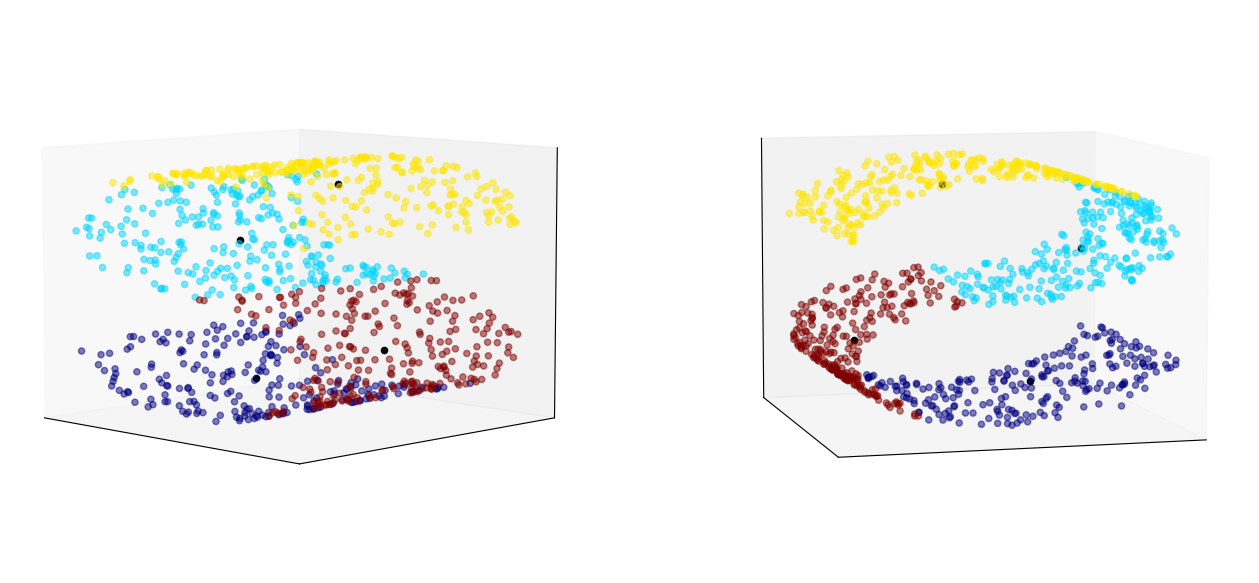

In [3]:
def compute_cluster_indexes(X,centers):
    # computes closest cluster for each point
    distances = [(X-c)**2 for c in centers] # distance to clusters
    distances = np.stack([d.sum(1) for d in distances]).T
    indexes = np.argmin(distances,axis=1) # index of min distance
    return indexes

# Random clusters
n_clusters = 4
centers = 10*np.random.randn(n_clusters*dx).reshape(n_clusters,dx)
diff = np.inf
while diff > 1e-4: 
    indexes = compute_cluster_indexes(X,centers)
    diff = 0
    for i in range(n_clusters):
        # Compute the barycenter
        barycenters = X[indexes==i].mean(axis=0)
        if np.isnan(barycenters).any():
            # New random cluster if barycenter is nan
            centers[i] = np.random.randn(dx)
            diff = np.inf
            pass
        else:
            # Move cluster to barycenter
            diff = max((barycenters-centers[i]).max(),diff)
            centers[i] = barycenters
indexes = compute_cluster_indexes(X,centers)

def plot_one(X,indexes,centers):
    ax.scatter(*X.T,c=indexes,alpha=0.5,cmap=plt.cm.jet)
    for c in centers:
        ax.scatter(*c,color='black')
    ax.set_xticks([]);ax.set_yticks([]);ax.set_zticks([])
fig = plt.figure(figsize=(16,8))
ax = fig.add_subplot(121,projection='3d', elev=7, azim=-45)
plot_one(X,indexes,centers)
ax = fig.add_subplot(122,projection='3d', elev=7, azim=75)
plot_one(X,indexes,centers)


## PCA

Text(0, 0.5, '$PCA_2$')

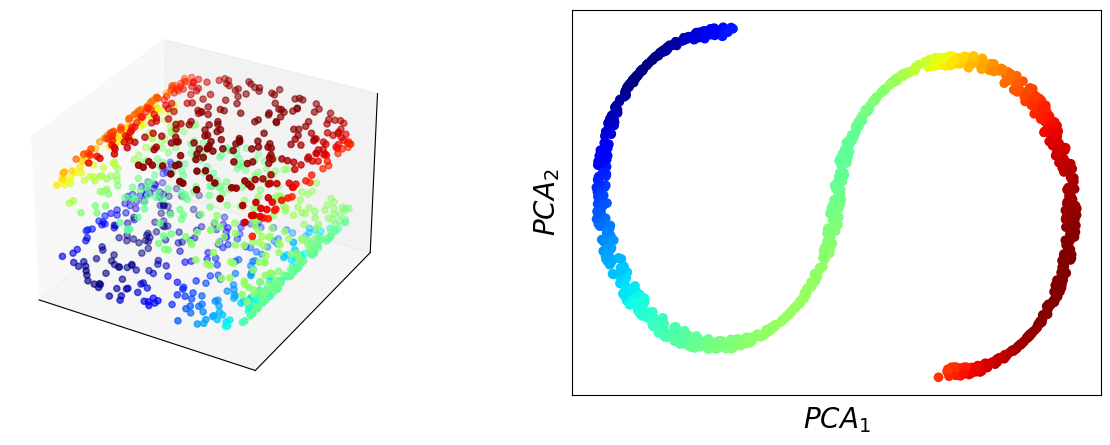

In [4]:
U,s,V = np.linalg.svd(X.T-X.mean(0).reshape(-1,1))
pca = U[:,:2].T.dot(X.T)

fig = plt.figure(figsize=(15,5))
ax = fig.add_subplot(1,2,1,projection='3d')
ax.scatter(*X.T,c=coloring,cmap=plt.cm.jet)
plt.xticks([]); plt.yticks([]); ax.set_zticks([])

ax = fig.add_subplot(1,2,2)
ax.scatter(*pca,c=coloring,cmap=plt.cm.jet)
plt.xticks([]); plt.yticks([])
plt.xlabel(r'$PCA_1$')
plt.ylabel(r'$PCA_2$')

## Diffusion maps

[Tutorial](https://inside.mines.edu/~whereman/talks/delaPorte-Herbst-Hereman-vanderWalt-DiffusionMaps-PRASA2008.pdf)

[Kaggle Example](https://www.kaggle.com/code/rahulrajpl/diffusion-map-for-manifold-learning)

Text(0, 0.5, '$DM_2$')

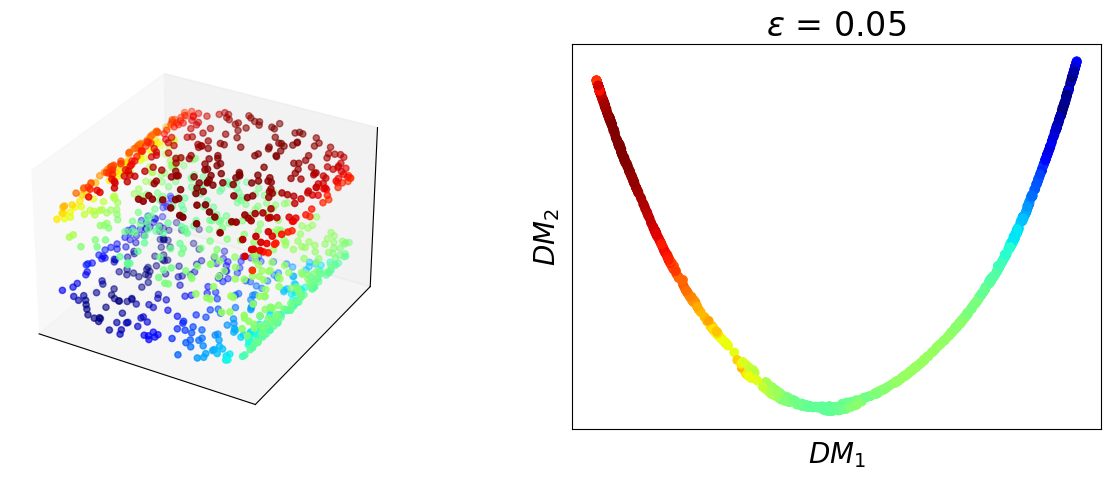

In [5]:
# Distances
dists = euclidean_distances(X,X)
def get_coords(eps):
    # Kernel
    K = np.exp(-dists**2/eps)
    r = K.sum(0)
    D = np.diag(1/r)
    # Probability (Kernel normalisation)
    P = np.matmul(D, K)
    P.sum(1).mean(),P.sum(1).std() 
    
    D_right = np.diag((r)**0.5)
    D_left = np.diag((r)**-0.5)
    P_prime = np.matmul(D_right, np.matmul(P,D_left))
    # Eigendecomposition
    eigvals, V = eigh(P_prime)
    idx = eigvals.argsort()[::-1]
    eigvals = eigvals[idx]
    V = V[:,idx]

    coords = np.matmul(D_left,V)[:,1:3]
    return coords

diffmap = get_coords(0.05)


fig = plt.figure(figsize=(15,5))
ax = fig.add_subplot(1,2,1,projection='3d')
ax.scatter(*X.T,c=coloring,cmap=plt.cm.jet)
plt.xticks([]); plt.yticks([]); ax.set_zticks([])

ax = fig.add_subplot(1,2,2)
plt.title(r'$\epsilon$ = {}'.format(0.05))
plt.scatter(*diffmap.T,c=coloring,cmap=plt.cm.jet)
plt.xticks([]); plt.yticks([])
plt.xlabel(r'$DM_1$')
plt.ylabel(r'$DM_2$')

## Locally Linear Embedding
[Tutorial](https://cs.nyu.edu/~roweis/lle/papers/lleintro.pdf)

[Kaggle example](https://www.kaggle.com/code/ukveteran/locally-linear-embedding-swiss-roll-data-jma/notebook)

Text(0, 0.5, '$LLE_2$')

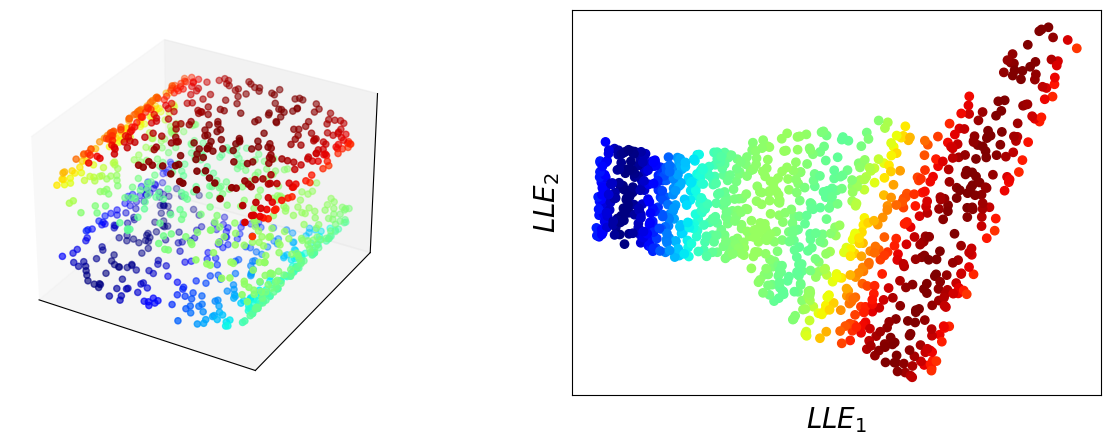

In [6]:
# KNN
n_neighbors = 12
knn = NearestNeighbors(n_neighbors=n_neighbors)
knn.fit(X)
distance_mat, neighbours_mat = knn.kneighbors(X)
# Local spaces construction
matrices = []
for n in neighbours_mat:
    matrices.append(np.stack([X[i] for i in n]))
matrices=np.stack(matrices)
# Local correlation and weights computation
stacked_X = np.stack([X])
stacked_X = np.moveaxis(stacked_X,0,1)
diff = stacked_X-matrices
W = np.zeros((X.shape[0],X.shape[0]))
for i,(n,dif) in enumerate(zip(neighbours_mat,diff)):
    C = np.matmul(dif,dif.T)
    C = C+np.identity(n_neighbors)*1e-4*np.trace(C)
    c_inv = np.linalg.inv(C)
    W[i][n] = c_inv.sum(1)/c_inv.sum()
# Eigenvectors computation
M = np.matmul((np.eye(X.shape[0])-W).T,(np.eye(X.shape[0])-W))
eigvals, eigvecs = eigh(M)
index = np.argsort(eigvals)
lle = eigvecs[:,index[1:3]]*np.sqrt(X.shape[0])

fig = plt.figure(figsize=(15,5))
ax = fig.add_subplot(1,2,1,projection='3d')
ax.scatter(*X.T,c=coloring,cmap=plt.cm.jet)
plt.xticks([]); plt.yticks([]); ax.set_zticks([])

ax = fig.add_subplot(1,2,2)
plt.scatter(*lle.T,c=coloring,cmap=plt.cm.jet)
plt.xticks([]);plt.yticks([])
plt.xlabel(r'$LLE_1$'); plt.ylabel(r'$LLE_2$')

## Isomap

/home/tau/emenier/miniconda3/envs/LED/lib/python3.9/site-packages/sklearn/manifold/_mds.py:299: FutureWarning: The default value of `normalized_stress` will change to `'auto'` in version 1.4. To suppress this warning, manually set the value of `normalized_stress`.
  warnings.warn(


Text(0, 0.5, '$ISO_2$')

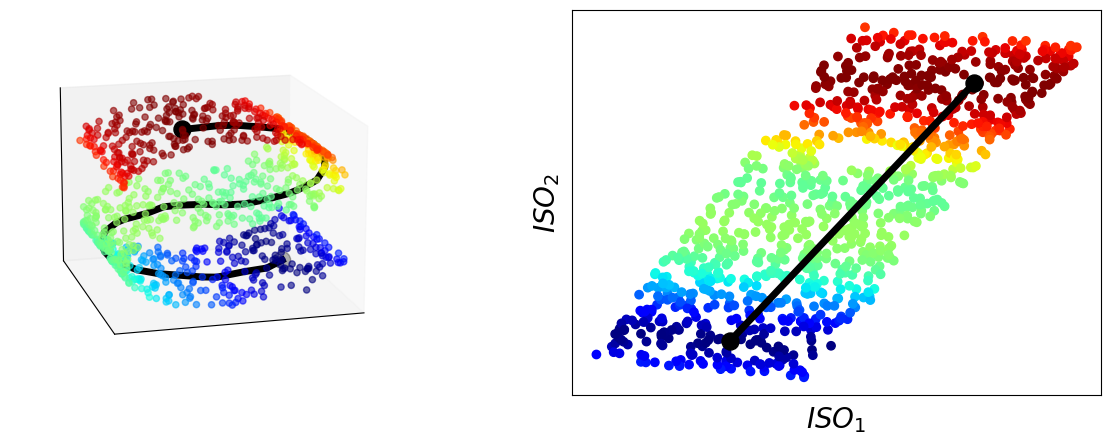

In [7]:
# KNN
n_neighbors = 12
knn = NearestNeighbors(n_neighbors=n_neighbors)
knn.fit(X)
distance_mat, neighbours_mat = knn.kneighbors(X)
# Geodesic distance
graph = np.zeros((X.shape[0],X.shape[0]))
for i,(dist,neighb) in enumerate(zip(distance_mat, neighbours_mat)):
    graph[i][neighb] = dist

distances, pred = scipy.sparse.csgraph.dijkstra(graph,return_predecessors=True,directed=False)
#Stress optimisation (MDS)
isomap,_ = manifold.smacof(distances)

# Constructing geodesic path
high, low = np.argmax(coloring), np.argmin(coloring)
points_hi = [high]
points_lo = [low]
while points_hi[-1] != points_lo[-1]:
    lo, hi = points_lo[-1], points_hi[-1]
    points_hi.append(pred[lo,hi])
    points_lo.append(pred[hi,lo])
path = points_hi+points_lo[::-1]

fig = plt.figure(figsize=(15,5))
ax = fig.add_subplot(1,2,1,projection='3d',elev=15, azim=75)
ax.scatter(*X.T,c=coloring,cmap=plt.cm.jet,alpha=0.6)
xp,yp,zp = X[path,0], X[path,1], X[path,2]
ax.plot(xp,yp,zp,lw=5,color='black')
ax.scatter(X[[high,low],0],X[[high,low],1],X[[high,low],2],s=150,color='black')
plt.xticks([]); plt.yticks([]); ax.set_zticks([])

ax = fig.add_subplot(1,2,2)
plt.scatter(*isomap.T,c=coloring,cmap=plt.cm.jet)
plt.plot(*isomap[[high,low]].T,lw=5,color='black')
ax.scatter(isomap[[high,low],0],isomap[[high,low],1],s=150,color='black')
plt.xticks([]);plt.yticks([])
plt.xlabel(r'$ISO_1$'); plt.ylabel(r'$ISO_2$')

## Neural Network

100%|██████████| 1000/1000 [00:27<00:00, 36.85it/s]


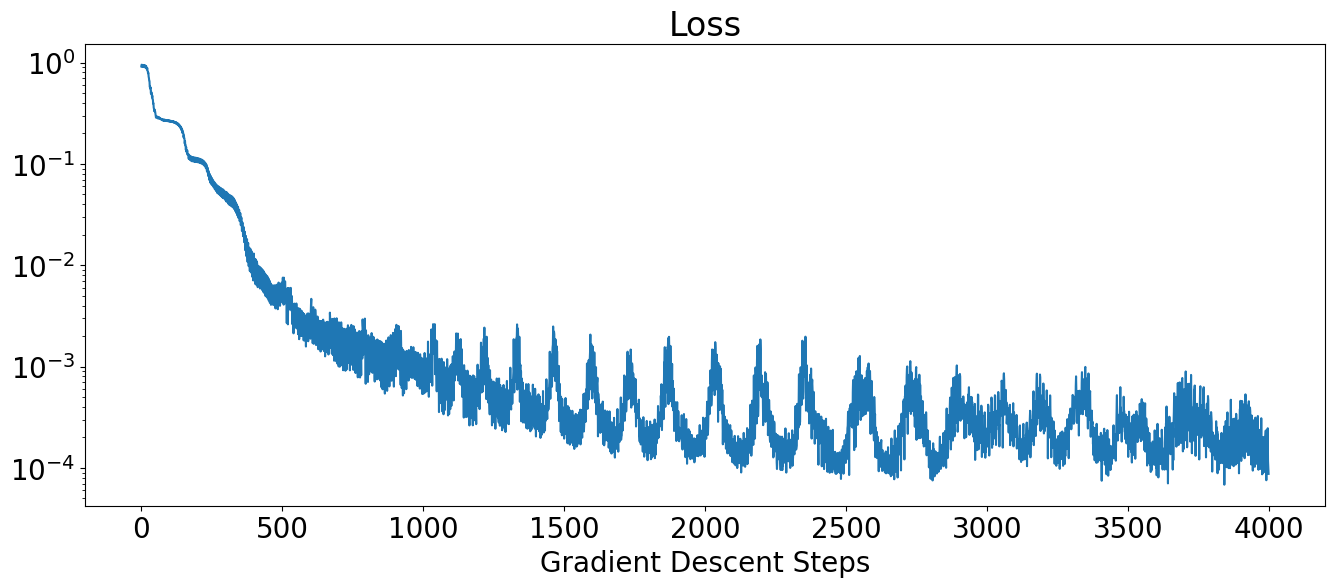

In [8]:
if torch.cuda.is_available(): dev=torch.device('cuda')
else: dev = torch.device('cpu')
    
X_torch = torch.tensor(X,dtype=torch.float).to(dev)
dz = 2
width = 64; act = nn.ReLU()
Enc = nn.Sequential(nn.Linear(X.shape[-1],width),act,
                   nn.Linear(width,width),act,
                   nn.Linear(width,width),act,
                   nn.Linear(width,width),act,
                   nn.Linear(width,dz)).to(dev)
Dec = nn.Sequential(nn.Linear(dz,width),act,
                   nn.Linear(width,width),act,
                   nn.Linear(width,width),act,
                   nn.Linear(width,width),act,
                   nn.Linear(width,X.shape[-1])).to(dev)
opt = torch.optim.Adam(list(Enc.parameters())+list(Dec.parameters()),lr=1e-3)
loader = DataLoader(TensorDataset(X_torch),batch_size=256)
lossfunc = nn.MSELoss()
losses = []
for j in tqdm(range(1000)):
    for i, (x,) in enumerate(loader):
        opt.zero_grad()
        loss = lossfunc(Dec(Enc(x)),x)
        loss.backward()
        opt.step()
        losses.append(loss.item())
autoenc = Enc(X_torch)
decoded = Dec(autoenc).detach().cpu().numpy()
autoenc = autoenc.detach().cpu().numpy()

plt.figure(figsize=(16,6))
plt.title('Loss'); plt.xlabel('Gradient Descent Steps')
plt.semilogy(losses)

Text(0.5, 0.92, 'Reconstruction')

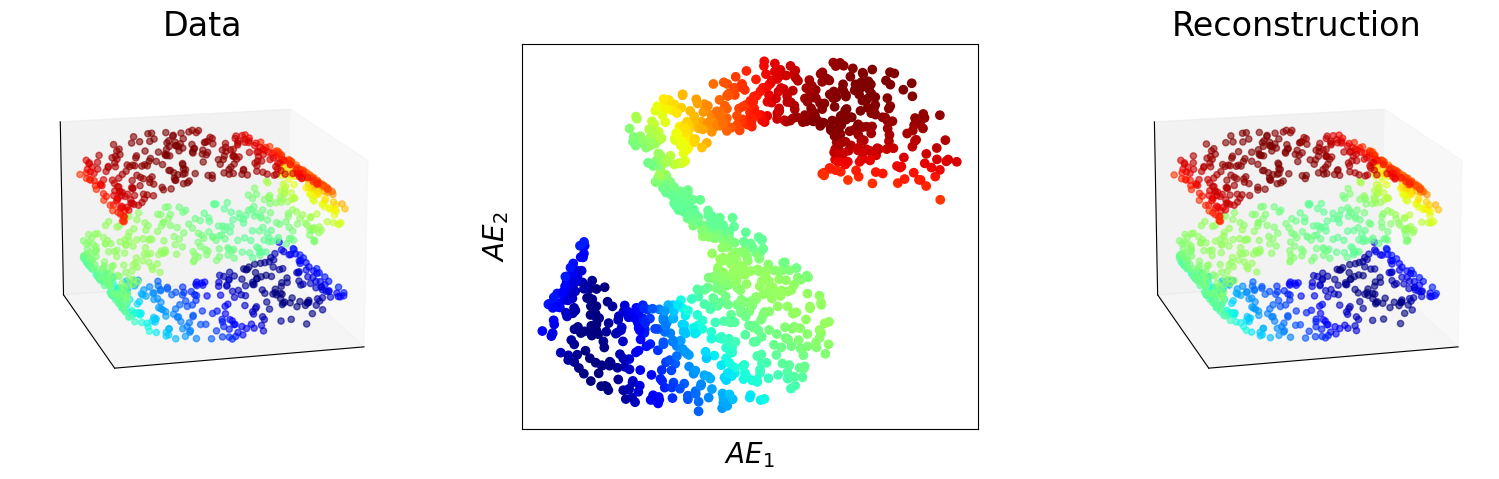

In [9]:
fig = plt.figure(figsize=(20,5))
ax = fig.add_subplot(1,3,1,projection='3d',elev=15, azim=75)
ax.scatter(*X.T,c=coloring,cmap=plt.cm.jet,alpha=0.6)
plt.xticks([]); plt.yticks([]); ax.set_zticks([])
ax.set_title('Data')

ax = fig.add_subplot(1,3,2)
plt.scatter(*autoenc.T,c=coloring,cmap=plt.cm.jet)
plt.xticks([]);plt.yticks([])
plt.xlabel(r'$AE_1$'); plt.ylabel(r'$AE_2$')

ax = fig.add_subplot(1,3,3,projection='3d',elev=15, azim=75)
ax.scatter(*decoded.T,c=coloring,cmap=plt.cm.jet,alpha=0.6)
plt.xticks([]); plt.yticks([]); ax.set_zticks([])
ax.set_title('Reconstruction')

## Side by Side

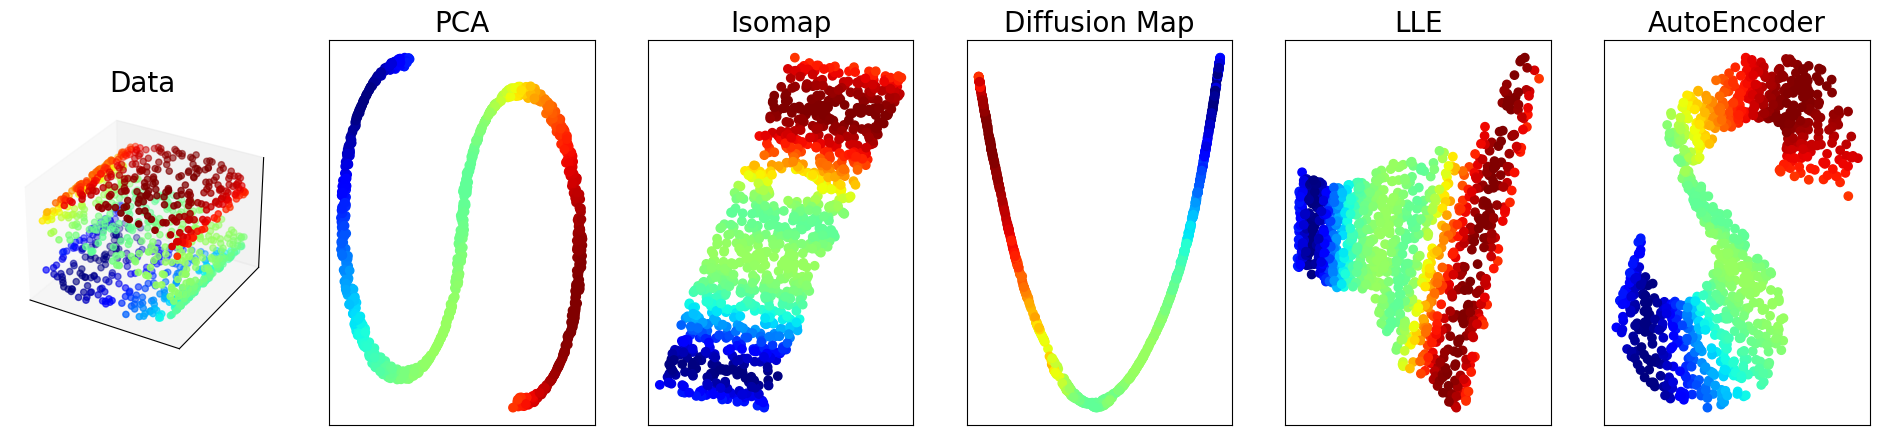

In [10]:
fs = 20

arrays = [pca.T,isomap,diffmap,lle,autoenc]
titles = ['PCA','Isomap','Diffusion Map','LLE','AutoEncoder']

fig = plt.figure(figsize=(4*(1+len(arrays)),5))
ax = fig.add_subplot(1,len(arrays)+1,1,projection='3d')
ax.scatter(*X.T,c=coloring,cmap=plt.cm.jet)
plt.xticks([]); plt.yticks([]); ax.set_zticks([])
plt.title('Data',fontsize=fs)
for i,(arr,titl) in enumerate(zip(arrays,titles)):
    ax = fig.add_subplot(1,len(arrays)+1,i+2)
    plt.title(titl,fontsize=fs)
    ax.scatter(*arr.T,c=coloring,cmap=plt.cm.jet)
    plt.xticks([]); plt.yticks([])

## Creating Readme

In [11]:
os.system('jupyter nbconvert --to markdown manifold_identification.ipynb')
os.system('mv manifold_identification.md README.md')


[NbConvertApp] WARNING | Config option `kernel_spec_manager_class` not recognized by `NbConvertApp`.
[NbConvertApp] Converting notebook manifold_identification.ipynb to markdown
[NbConvertApp] Support files will be in manifold_identification_files/
[NbConvertApp] Making directory manifold_identification_files
[NbConvertApp] Making directory manifold_identification_files
[NbConvertApp] Making directory manifold_identification_files
[NbConvertApp] Making directory manifold_identification_files
[NbConvertApp] Making directory manifold_identification_files
[NbConvertApp] Making directory manifold_identification_files
[NbConvertApp] Making directory manifold_identification_files
[NbConvertApp] Making directory manifold_identification_files
[NbConvertApp] Making directory manifold_identification_files
[NbConvertApp] Writing 11272 bytes to manifold_identification.md


0